# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Understanding the datasets

In [8]:
# glimpse at the general population dataset
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [9]:
# a quick look at the mail-order company customers dataset
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
# load and view the attribute levels dataset
levels = pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx", header = 1)
levels.head(10)

,Information level,Attribute,Description,Additional notes
NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
NaN,NaN,ANREDE_KZ,gender,NaN
NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
NaN,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [11]:
#load the attibute values
attributes = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header = 1, index = False)
attributes.head(15)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,NaN,NaN,1,< 30 years
NaN,NaN,NaN,2,30 - 45 years
NaN,NaN,NaN,3,46 - 60 years
NaN,NaN,NaN,4,> 60 years


The index contains NaNs, so I will replace it. Also, I will forward fill the "Atttribute" and "Description" columns as their existing values seem to be applicable until the next existing value.

In [12]:
# drop index
attributes.reset_index(drop=True, inplace=True) 
                 
# Forward fill the attribute and description columns
attributes['Attribute'] = attributes['Attribute'].ffill()
attributes['Description'] = attributes['Description'].ffill()

# see the first 15 rows
attributes.head(15)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


## Data cleaning

To start with, I fix problems that caused the error message when loading the datasets. 

In [13]:
# check why there was an error message about columns 18 and 19
azdias.iloc[:,19].unique(), azdias.iloc[:,20].unique()

(array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
        41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
        '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
        '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'], dtype=object),
 array([  2.,   5.,   3.,   4.,   1.,   6.,  nan]))

In [14]:
# check why there was an error message about columns 18 and 19
customers.iloc[:,19].unique(), customers.iloc[:,20].unique()

(array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
        51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
        '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
        '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'], dtype=object),
 array([  5.,  nan,   2.,   6.,   4.,   1.,   3.]))

It seems values X, XX, and nan are the cause of the cause of the warnings received when loading the data. For now, I will first replace X, XX, and nans to -1, which is consistently used as a value for unknown values. I will later replace all unknown values with NaNs

In [15]:
def replace_values(df, cols):
    """
    Replaces 'X', 'XX' and 'nan' values with -1 in the general population and customer datasets. 
    Casts these columns as floats.
    
    Args: 
    df - general population dataset or customers dataset
    cols - columns that contain 'X', 'XX' or 'nan'
    
    Returns: Dataframe with 'X', 'XX' or 'nan' values replaced with -1
    """
    
    df.iloc[:, cols] = df.iloc[:, cols].replace({"X": -1, "XX": -1, "nan": -1})
    df.iloc[:, cols] = df.iloc[:, cols].astype(float)
    
    return df

In [17]:
#see the problematic column heads
cols = [19, 20]
azdias.iloc[:, cols].head()

,CAMEO_INTL_2015,CJT_GESAMTTYP
0,NaN,2.0
1,51,5.0
2,24,3.0
3,12,2.0
4,43,5.0


In [18]:
customers.iloc[:, cols].head()

,CAMEO_INTL_2015,CJT_GESAMTTYP
0,13,5.0
1,NaN,NaN
2,34,2.0
3,24,2.0
4,41,6.0


In [20]:
#apply the function to replace values in columns 18 and 19
cols = [19, 20]

azdias = replace_values(azdias, cols)
customers = replace_values(customers, cols)

In [15]:
# check if the values have been correctly replaced
azdias_copy.iloc[:,19].unique(), azdias_copy.iloc[:,20].unique(), customers_copy.iloc[:,19].unique(), customers_copy.iloc[:,20].unique()

(array([ nan,  51.,  24.,  12.,  43.,  54.,  22.,  14.,  13.,  15.,  33.,
         41.,  34.,  55.,  25.,  23.,  31.,  52.,  35.,  45.,  44.,  32.,
         -1.]),
 array([  2.,   5.,   3.,   4.,   1.,   6.,  nan]),
 array([ 13.,  nan,  34.,  24.,  41.,  23.,  15.,  55.,  14.,  22.,  43.,
         51.,  33.,  25.,  44.,  54.,  32.,  12.,  35.,  31.,  45.,  52.,
         -1.]),
 array([  5.,  nan,   2.,   6.,   4.,   1.,   3.]))

In [21]:
# I see there are still nans, let's make sure they are appropriate NaN values by performing simple arithmetics on the columns
azdias.iloc[:,19].sum(), customers.iloc[:,19].sum()

(28106233.0, 4141916.0)

**Convert unknowns to NaNs**

In the attributes dataset, it was shown that unknown values are given by various values. I first prepare a dataset showing the columns that have unknown values

In [22]:
# attributes with uknown values
unknown_list = attributes[attributes["Meaning"] == "unknown"]

In [23]:
#number of attributes that contain unknown values
len(unknown_list)

232

In [24]:
unknown_list.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


The first step to replace the unknown values, we need a function to create a set of values for each column that contains unknown values.

In [25]:
def get_unknown_values(col, unknown_list):
    """
    Args: 
    col - columns to retrieve unknown values from
    df - Dataframe containing attribute values
    
    Returns unkown values for the selected columnn"""
    
    
    
    unknown_values = unknown_list[unknown_list["Attribute"] == col]["Value"]
    unknown_values = unknown_values.astype(str).str.cat(sep=",")
    unknown_values = [int(x) for x in unknown_values.split(",")]
      
    return set(unknown_values)

In [91]:
# test the function on a column
ZABEOTYP_unknown = get_unknown_values("ZABEOTYP", unknown_list)
ZABEOTYP_unknown

{-1, 9}

In [26]:
def replace_unknown_col(df, col, unknown_list):
    '''
    Iterates through the values of a chosen column. 
    If a value is contained in the list of unknown values, the value is replaced with NaN. 
    If a value doesn't belong to unknown values, the value is retained. 
    
    Args:
    df - dataset 
    col - column containing unknown values
    unknown list - attributes dataset that contains only those attributes that have unknown values
    
    Returns:
    column with unknown values replaced with NaNs
    '''
    unknown_values = get_unknown_values(col, unknown_list)
    list2 = []
    for val in df[col].values:
        if val in unknown_values:
            list2.append(np.nan)
        else:
            list2.append(val)
    
    df[col] =  np.array(list2)
            
    return df[col]


In [27]:
def replace_unknowns(df, unknown_list, verbose=False):
    """
    Iterates through all columns of the dataset. 
    If the column has unknown values, the unknown values are replaced with NaNs.
    
    Returns:
    dataset with columns, in which unknown values are replaced with NaNs.
    """
    for col in unknown_list.Attribute:
        unknown_values = get_unknown_values(col, unknown_list)
        if verbose:
            print("Replacing {} to NaN in column {}".format(unknown_values, col))
        if col in df.columns:
            df[col] = replace_unknown_col(df, col, unknown_list)
    return df

Next, I apply the three-part function to clean the two datasets.

In [28]:
#resplace unknowns in the general population dataset
replace_unknowns(azdias, unknown_list, verbose = True)

Replacing {-1} to NaN in column AGER_TYP
Replacing {0, -1} to NaN in column ALTERSKATEGORIE_GROB
Replacing {0, -1} to NaN in column ANREDE_KZ
Replacing {-1} to NaN in column BALLRAUM
Replacing {-1} to NaN in column BIP_FLAG
Replacing {-1} to NaN in column CAMEO_DEUG_2015
Replacing {-1} to NaN in column CAMEO_DEUINTL_2015
Replacing {0} to NaN in column CJT_GESAMTTYP
Replacing {-1} to NaN in column D19_KK_KUNDENTYP
Replacing {-1} to NaN in column EWDICHTE
Replacing {-1} to NaN in column FINANZTYP
Replacing {-1} to NaN in column FINANZ_ANLEGER
Replacing {-1} to NaN in column FINANZ_HAUSBAUER
Replacing {-1} to NaN in column FINANZ_MINIMALIST
Replacing {-1} to NaN in column FINANZ_SPARER
Replacing {-1} to NaN in column FINANZ_UNAUFFAELLIGER
Replacing {-1} to NaN in column FINANZ_VORSORGER
Replacing {0, -1} to NaN in column GEBAEUDETYP
Replacing {0, -1} to NaN in column GEOSCORE_KLS7
Replacing {0, -1} to NaN in column HAUSHALTSSTRUKTUR
Replacing {-1} to NaN in column HEALTH_TYP
Replacing {0,

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [29]:
# replace unknowns in the customers dataset
replace_unknowns(customers, unknown_list, verbose = True)

Replacing {-1} to NaN in column AGER_TYP
Replacing {0, -1} to NaN in column ALTERSKATEGORIE_GROB
Replacing {0, -1} to NaN in column ANREDE_KZ
Replacing {-1} to NaN in column BALLRAUM
Replacing {-1} to NaN in column BIP_FLAG
Replacing {-1} to NaN in column CAMEO_DEUG_2015
Replacing {-1} to NaN in column CAMEO_DEUINTL_2015
Replacing {0} to NaN in column CJT_GESAMTTYP
Replacing {-1} to NaN in column D19_KK_KUNDENTYP
Replacing {-1} to NaN in column EWDICHTE
Replacing {-1} to NaN in column FINANZTYP
Replacing {-1} to NaN in column FINANZ_ANLEGER
Replacing {-1} to NaN in column FINANZ_HAUSBAUER
Replacing {-1} to NaN in column FINANZ_MINIMALIST
Replacing {-1} to NaN in column FINANZ_SPARER
Replacing {-1} to NaN in column FINANZ_UNAUFFAELLIGER
Replacing {-1} to NaN in column FINANZ_VORSORGER
Replacing {0, -1} to NaN in column GEBAEUDETYP
Replacing {0, -1} to NaN in column GEOSCORE_KLS7
Replacing {0, -1} to NaN in column HAUSHALTSSTRUKTUR
Replacing {-1} to NaN in column HEALTH_TYP
Replacing {0,

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1.0,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
6,143904,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
7,143910,1.0,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,3,FOOD,SINGLE_BUYER,0,1,4
8,102160,2.0,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,9.0,6.0,3.0,4.0,3,COSMETIC,MULTI_BUYER,0,2,4
9,102173,1.0,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,4.0,2.0,9.0,5.0,1,COSMETIC,MULTI_BUYER,0,1,3


In [30]:
#show columns that are of object type
#customers_copy.loc[:, customers_copy.dtypes == object]

In [31]:
#show columns that are of object type
#azdias_copy.loc[:, customers_copy.dtypes == object]

## Dealing with missing data

In [32]:
def percent_missing(df):
    '''
    Calculates the percentage of missing values in a dataset.
    
    Args:
    inputs: Dataset
    output: Dataset showing the percentage of missing values per column.
    '''
    percent_missing = df.isnull().sum()* 100/len(df)
    percent_missing_df = pd.DataFrame({'col': df.columns,
                                 'percent_missing': percent_missing})
    return percent_missing_df

In [34]:
# table of missing values in customers dataset
missing_customers = percent_missing(customers)

In [37]:
missing_customers.describe()

,percent_missing
count,369.000000
mean,20.313980
std,15.797833
min,0.000000
25%,1.548640
50%,26.757352
75%,26.757352
max,99.876860


In [57]:
missing_customers["percent_missing"].sort_values(ascending = False).head(15)

ALTER_KIND4       99.876860
ALTER_KIND3       99.334732
TITEL_KZ          98.793647
ALTER_KIND2       97.338927
ALTER_KIND1       93.860748
KK_KUNDENTYP      58.406382
KBA05_BAUMAX      57.153069
AGER_TYP          48.059504
EXTSEL992         44.498883
KKK               31.340137
REGIOTYP          31.340137
W_KEIT_KIND_HH    29.708534
KBA05_AUTOQUOT    29.696533
KBA05_SEG7        29.696012
KBA05_SEG6        29.696012
Name: percent_missing, dtype: float64

In [58]:
missing_azdias["percent_missing"].sort_values(ascending = False).head(15)

ALTER_KIND4                  99.864792
TITEL_KZ                     99.757636
ALTER_KIND3                  99.307691
ALTER_KIND2                  96.690047
ALTER_KIND1                  90.904837
AGER_TYP                     76.019640
EXTSEL992                    73.399639
KK_KUNDENTYP                 65.596749
KBA05_BAUMAX                 53.468668
ALTERSKATEGORIE_FEIN         29.504130
D19_KONSUMTYP                28.849522
D19_VERSI_ONLINE_QUOTE_12    28.849522
D19_TELKO_ONLINE_QUOTE_12    28.849522
D19_LETZTER_KAUF_BRANCHE     28.849522
D19_LOTTO                    28.849522
Name: percent_missing, dtype: float64

In [38]:
# table of missing values in general population dataset
missing_azdias = percent_missing(azdias)

In [39]:
missing_azdias.describe()

,percent_missing
count,366.000000
mean,11.238533
std,13.709766
min,0.000000
25%,0.544646
50%,11.871354
75%,13.073637
max,99.864792


In the customer dataset, 25% of the variables contain more than 26.76% missing values. This is bigger than the upper quartile of the general population dataset, which is 13%. So, I first make a list of the columns missing more than 25% values in both datasets and compare them. 

In [40]:
missing_customers.head()

,col,percent_missing
LNR,LNR,0.000000
AGER_TYP,AGER_TYP,48.059504
AKT_DAT_KL,AKT_DAT_KL,24.312817
ALTER_HH,ALTER_HH,24.312817
ALTER_KIND1,ALTER_KIND1,93.860748


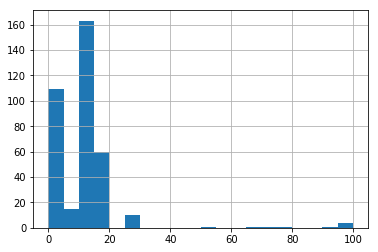

In [62]:
missing_azdias["percent_missing"].hist(bins = 20)

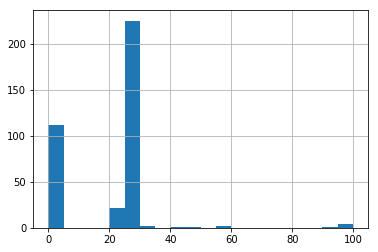

In [63]:
missing_customers["percent_missing"].hist(bins = 20)

In [69]:
missing_azdias_list = set(missing_azdias[missing_azdias["percent_missing"]>33]["col"])
missing_customers_list = set(missing_customers[missing_customers["percent_missing"]>33]["col"])

In [74]:
#any difference between the variables missing more than 33% values?
np.setdiff1d(missing_azdias_list, missing_customers_list)

array([], dtype=object)

In [70]:
#find the union of three sets to come up with columns to drop in both datasets
to_drop = missing_azdias_list.union(missing_customers_list)

In [76]:
len(to_drop)

9

## Feature engineering

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#Deal with NaNs before PCA by imputing, but imputation for the supervised learning part of the project I will impute the datasets within the ML pipeline as different imputation techniques may have implications for the accuracy of the predictions

imputer = SimpleImputer(strategy= 'most_frequent')
    imputed_df = pd.DataFrame(imputer.fit_transform(df))
    imputed_df.columns = df.columns
    imputed_df.index = df.index


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')